# Skin Cancer Image Processing and Modelin Iterations

In this notebook, we will use final dataset from [Data Exploration notebook](https://github.com/emykes/SkinCancerImageClassification/blob/main/Notebooks/Data_Exp_512x512.ipynb). Here we will implement preprocessing steps to the image data to prepare them for modeling. After preprocessing, we will build baseline model by multi-layer perceptron and start iterating on convolutional neural networks to imrpove modeling results in order to reach the best final model. 

In [1]:
# Import Relevant Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from tensorflow import keras
from keras import models, layers
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, Activation, BatchNormalization
from keras.regularizers import l2
from tensorflow.keras.optimizers import Adam, SGD

from sklearn.utils import class_weight
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import warnings
warnings.filterwarnings('ignore')

np.random.seed(123)

In [2]:
# Define modeling results display function:
def visualize_modeling_results(results):
    '''   
    Input: model history results
    '''
    history = results.history
    
    plt.figure(figsize=(8,5))
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.legend(['train', 'validation'], loc='upper right')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    plt.figure(figsize=(8,5))
    plt.plot(history['accuracy'])
    plt.plot(history['val_accuracy'])
    plt.legend(['train', 'validation'], loc='lower left')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()

## 1. Data Preperation

In [4]:
# Reading in the final dataset from Data_Exploration.ipynb
df = pd.read_csv('../data/ISIC_FINAL_DATASET_512x512.csv')
df

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target,tfrecord,width,height,path,source,ext
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0,0,6000,4000,../data/ISIC_IMAGES_512x512/ISIC2020/image2020...,NaN,NaN
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0,0,6000,4000,../data/ISIC_IMAGES_512x512/ISIC2020/image2020...,NaN,NaN
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0,6,1872,1053,../data/ISIC_IMAGES_512x512/ISIC2020/image2020...,NaN,NaN
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0,0,1872,1053,../data/ISIC_IMAGES_512x512/ISIC2020/image2020...,NaN,NaN
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0,11,6000,4000,../data/ISIC_IMAGES_512x512/ISIC2020/image2020...,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12431,ISIC_0024302,-1,female,25.0,NaN,melanoma,malignant,1,29,3008,2000,../data/ISIC_IMAGES_512x512/Add_ISIC/image_add...,2018 JID Editorial Images,jpg
12432,ISIC_0024303,-1,male,60.0,NaN,squamous cell carcinoma,malignant,1,29,3008,2000,../data/ISIC_IMAGES_512x512/Add_ISIC/image_add...,2018 JID Editorial Images,jpg
12433,ISIC_0024304,-1,male,70.0,NaN,squamous cell carcinoma,malignant,1,29,3008,2000,../data/ISIC_IMAGES_512x512/Add_ISIC/image_add...,2018 JID Editorial Images,jpg
12434,ISIC_0024305,-1,male,85.0,NaN,squamous cell carcinoma,malignant,1,29,4288,2848,../data/ISIC_IMAGES_512x512/Add_ISIC/image_add...,2018 JID Editorial Images,jpg


- All images in the final dataset has size of 512x512.

In [5]:
df['benign_malignant'].value_counts()

benign       6750
malignant    5686
Name: benign_malignant, dtype: int64

In [6]:
df['target'].value_counts()

0    6750
1    5686
Name: target, dtype: int64

In [7]:
# Define X and y 
X = df[['image_name', 'path', 'sex', 'age_approx', 'anatom_site_general_challenge']]
y = df['benign_malignant']

In [8]:
X

,image_name,path,sex,age_approx,anatom_site_general_challenge
0,ISIC_2637011,../data/ISIC_IMAGES_512x512/ISIC2020/image2020...,male,45.0,head/neck
1,ISIC_0015719,../data/ISIC_IMAGES_512x512/ISIC2020/image2020...,female,45.0,upper extremity
2,ISIC_0052212,../data/ISIC_IMAGES_512x512/ISIC2020/image2020...,female,50.0,lower extremity
3,ISIC_0068279,../data/ISIC_IMAGES_512x512/ISIC2020/image2020...,female,45.0,head/neck
4,ISIC_0074268,../data/ISIC_IMAGES_512x512/ISIC2020/image2020...,female,55.0,upper extremity
...,...,...,...,...,...
12431,ISIC_0024302,../data/ISIC_IMAGES_512x512/Add_ISIC/image_add...,female,25.0,NaN
12432,ISIC_0024303,../data/ISIC_IMAGES_512x512/Add_ISIC/image_add...,male,60.0,NaN
12433,ISIC_0024304,../data/ISIC_IMAGES_512x512/Add_ISIC/image_add...,male,70.0,NaN
12434,ISIC_0024305,../data/ISIC_IMAGES_512x512/Add_ISIC/image_add...,male,85.0,NaN


In [9]:
# Train - Test Set Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [10]:
# Train - Validation set Split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [11]:
# Train dataframe
df_train = pd.concat([X_train, y_train], axis=1)
print(f"Train dataset: \n {df_train['benign_malignant'].value_counts()}")
df_train

Train dataset: 
 benign       4845
malignant    4108
Name: benign_malignant, dtype: int64


,image_name,path,sex,age_approx,anatom_site_general_challenge,benign_malignant
2034,ISIC_0714807,../data/ISIC_IMAGES_512x512/ISIC2020/image2020...,female,20.0,upper extremity,benign
6216,ISIC_1984995,../data/ISIC_IMAGES_512x512/ISIC2020/image2020...,female,30.0,palms/soles,benign
1848,ISIC_0663588,../data/ISIC_IMAGES_512x512/ISIC2020/image2020...,male,65.0,torso,benign
11624,ISIC_0071693,../data/ISIC_IMAGES_512x512/ISIC2019/image2019...,female,40.0,head/neck,malignant
4775,ISIC_1558731,../data/ISIC_IMAGES_512x512/ISIC2020/image2020...,female,45.0,torso,benign
...,...,...,...,...,...,...
2578,ISIC_0884397,../data/ISIC_IMAGES_512x512/ISIC2020/image2020...,male,40.0,torso,benign
11825,ISIC_0072990,../data/ISIC_IMAGES_512x512/ISIC2019/image2019...,female,50.0,anterior torso,malignant
672,ISIC_0307958,../data/ISIC_IMAGES_512x512/ISIC2020/image2020...,female,80.0,palms/soles,benign
6213,ISIC_1984152,../data/ISIC_IMAGES_512x512/ISIC2020/image2020...,female,55.0,torso,benign


In [12]:
# Validation dataframe
df_val = pd.concat([X_val, y_val], axis=1)
print(f"Test dataset: \n {df_val['benign_malignant'].value_counts()}")
df_val

Test dataset: 
 benign       1211
malignant    1028
Name: benign_malignant, dtype: int64


,image_name,path,sex,age_approx,anatom_site_general_challenge,benign_malignant
8227,ISIC_0028219,../data/ISIC_IMAGES_512x512/ISIC2019/image2019...,male,45.0,upper extremity,malignant
3879,ISIC_1289942,../data/ISIC_IMAGES_512x512/ISIC2020/image2020...,male,60.0,torso,benign
2819,ISIC_0954236,../data/ISIC_IMAGES_512x512/ISIC2020/image2020...,male,45.0,lower extremity,benign
11196,ISIC_0068438,../data/ISIC_IMAGES_512x512/ISIC2019/image2019...,female,75.0,palms/soles,malignant
1808,ISIC_0652205,../data/ISIC_IMAGES_512x512/ISIC2020/image2020...,male,40.0,lower extremity,benign
...,...,...,...,...,...,...
10278,ISIC_0062029,../data/ISIC_IMAGES_512x512/ISIC2019/image2019...,female,80.0,anterior torso,malignant
5484,ISIC_1768051,../data/ISIC_IMAGES_512x512/ISIC2020/image2020...,female,70.0,lower extremity,benign
4342,ISIC_1431236,../data/ISIC_IMAGES_512x512/ISIC2020/image2020...,female,55.0,torso,benign
3993,ISIC_1326366,../data/ISIC_IMAGES_512x512/ISIC2020/image2020...,male,65.0,lower extremity,benign


In [13]:
# Test (Holdout) dataframe:
df_test = pd.concat([X_test, y_test], axis=1)
print(f"Test dataset: \n {df_test['benign_malignant'].value_counts()}")
df_test

Test dataset: 
 benign       694
malignant    550
Name: benign_malignant, dtype: int64


,image_name,path,sex,age_approx,anatom_site_general_challenge,benign_malignant
10405,ISIC_0062914,../data/ISIC_IMAGES_512x512/ISIC2019/image2019...,female,50.0,lower extremity,malignant
6392,ISIC_2038024,../data/ISIC_IMAGES_512x512/ISIC2020/image2020...,male,45.0,lower extremity,benign
1483,ISIC_0552960,../data/ISIC_IMAGES_512x512/ISIC2020/image2020...,male,60.0,lower extremity,benign
4190,ISIC_1384527,../data/ISIC_IMAGES_512x512/ISIC2020/image2020...,female,35.0,lower extremity,benign
8635,ISIC_0032724,../data/ISIC_IMAGES_512x512/ISIC2019/image2019...,female,50.0,posterior torso,malignant
...,...,...,...,...,...,...
8450,ISIC_0030929,../data/ISIC_IMAGES_512x512/ISIC2019/image2019...,female,55.0,upper extremity,malignant
4949,ISIC_1611285,../data/ISIC_IMAGES_512x512/ISIC2020/image2020...,male,30.0,lower extremity,benign
2239,ISIC_0772957,../data/ISIC_IMAGES_512x512/ISIC2020/image2020...,male,45.0,torso,benign
10402,ISIC_0062891,../data/ISIC_IMAGES_512x512/ISIC2019/image2019...,female,35.0,anterior torso,malignant


## 2. Image Preprocessing

In [14]:
# Instantiating a generator object and normalizing the RGB values:
generator = ImageDataGenerator(rescale=1./255)


# Creating the generator for the training data
train_generator = generator.flow_from_dataframe(df_train, x_col='path', y_col='benign_malignant',
                                                # Re-sizing images to 64x64
                                                target_size=(64, 64),
                                                batch_size=len(df_train),
                                                seed=42,
                                                class_mode='binary')


# Creating the generator for the validation data
val_generator = generator.flow_from_dataframe(df_val, x_col='path', y_col='benign_malignant',
                                              # Re-sizing images to 64x64
                                              target_size=(64, 64),
                                              batch_size=len(df_val),
                                              seed=42,
                                              class_mode='binary')


# Setting aside a testing/hold-out set
test_generator =  generator.flow_from_dataframe(df_test, x_col='path', y_col='benign_malignant',
                                                # Re-sizing images to 64x64
                                                target_size=(64, 64),
                                                batch_size=len(df_test),
                                                seed=42,
                                                class_mode='binary')

Found 8953 validated image filenames belonging to 2 classes.
Found 2239 validated image filenames belonging to 2 classes.
Found 1244 validated image filenames belonging to 2 classes.


In [15]:
train_generator.class_indices

{'benign': 0, 'malignant': 1}

In [16]:
# Create the data sets
train_images, train_labels = next(train_generator)
val_images, val_labels = next(val_generator)
test_images, test_labels = next(test_generator)

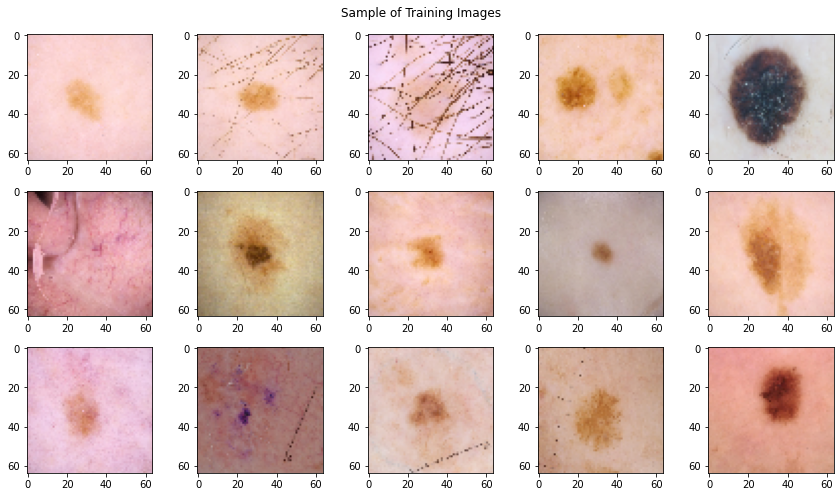

In [17]:
# Visualize Training images sample
fig, axes = plt.subplots(3, 5, figsize=(12, 7))
for i in range(15):
    img = train_images[i]
    ax = axes[i//5, i%5]
    ax.imshow(img)
fig.suptitle('Sample of Training Images')
plt.tight_layout()
plt.show()

In [18]:
# Check classes
print(f"Train data set classes, {train_generator.class_indices}")
print(f"Validation data set classes, {val_generator.class_indices}")
print(f"Test data set classes, {test_generator.class_indices}")

Train data set classes, {'benign': 0, 'malignant': 1}
Validation data set classes, {'benign': 0, 'malignant': 1}
Test data set classes, {'benign': 0, 'malignant': 1}


In [19]:
# Explore dataset again
m_train = train_images.shape[0]
m_val = val_images.shape[0]
m_test = test_images.shape[0]

print ("Number of training samples: " + str(m_train))
print ("Number of validation samples: " + str(m_val))
print ("Number of test samples: " + str(m_test))

print ("train_images shape: " + str(train_images.shape))   
print ("train_labels shape: " + str(train_labels.shape))

print ("val_images shape: " + str(val_images.shape))
print ("val_labels shape: " + str(val_labels.shape))

print ("test_images shape: " + str(test_images.shape))
print ("test_labels shape: " + str(test_labels.shape))

Number of training samples: 8953
Number of validation samples: 2239
Number of test samples: 1244
train_images shape: (8953, 64, 64, 3)
train_labels shape: (8953,)
val_images shape: (2239, 64, 64, 3)
val_labels shape: (2239,)
test_images shape: (1244, 64, 64, 3)
test_labels shape: (1244,)


In [20]:
# Reshaping image sets:
train_img = train_images.reshape(train_images.shape[0], -1)
val_img = val_images.reshape(val_images.shape[0], -1)
test_img = test_images.reshape(test_images.shape[0], -1)

print(train_img.shape)
print(val_img.shape)
print(test_img.shape)

(8953, 12288)
(2239, 12288)
(1244, 12288)


## 3. Modeling with Neural Networks

### 3.1. Baseline Model - Multi-Layer Perceptron

As a baseline model, we will start using multi-layer perceptron, and then use this model to iterate to find final 'best' model. 

In [21]:
# Fit a Neural Network Model
model = models.Sequential()

# Adding layers
model.add(layers.Dense(20, activation='relu', input_shape=(train_img.shape[1],))) # input layer
model.add(layers.Dense(12, activation='relu'))   # hidden layer
model.add(layers.Dense(5, activation='relu'))    # hidden layer
model.add(layers.Dense(1, activation='sigmoid')) # output layer

In [22]:
# visalize model layers:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 20)                245780    
_________________________________________________________________
dense_1 (Dense)              (None, 12)                252       
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 65        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 6         
Total params: 246,103
Trainable params: 246,103
Non-trainable params: 0
_________________________________________________________________


In [23]:
# Compile and fit the model:
model.compile(optimizer='sgd',
              loss='binary_crossentropy',
             metrics=['accuracy', 'Recall', 'Precision', 'AUC'])

history = model.fit(train_img,
                    train_labels,
                    epochs=30,
                    batch_size=32,  # mini batches of 32 units!
                    validation_data=(val_img, val_labels))

Epoch 1/30
280/280 [==============================] - 2s 6ms/step - loss: 0.5656 - accuracy: 0.6823 - recall: 0.3905 - precision: 0.8251 - auc: 0.7758 - val_loss: 0.5598 - val_accuracy: 0.7017 - val_recall: 0.8181 - val_precision: 0.6362 - val_auc: 0.8186
Epoch 2/30
280/280 [==============================] - 1s 4ms/step - loss: 0.4746 - accuracy: 0.7659 - recall: 0.6020 - precision: 0.8429 - auc: 0.8462 - val_loss: 0.5101 - val_accuracy: 0.7320 - val_recall: 0.4553 - val_precision: 0.9213 - val_auc: 0.8618
Epoch 3/30
280/280 [==============================] - 1s 4ms/step - loss: 0.4542 - accuracy: 0.7799 - recall: 0.6271 - precision: 0.8544 - auc: 0.8603 - val_loss: 0.4484 - val_accuracy: 0.7847 - val_recall: 0.6732 - val_precision: 0.8258 - val_auc: 0.8759
Epoch 4/30
280/280 [==============================] - 1s 4ms/step - loss: 0.4290 - accuracy: 0.7948 - recall: 0.6480 - precision: 0.8719 - auc: 0.8787 - val_loss: 0.4402 - val_accuracy: 0.7874 - val_recall: 0.6975 - val_precision: 0

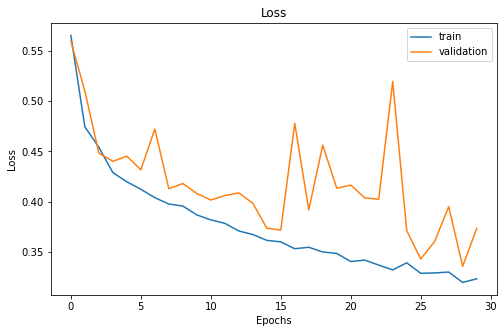

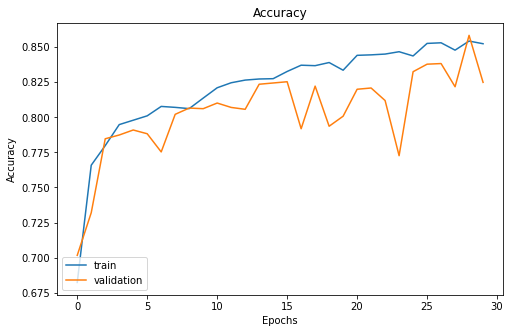

In [24]:
# Visualize the modeling results:
visualize_modeling_results(history)

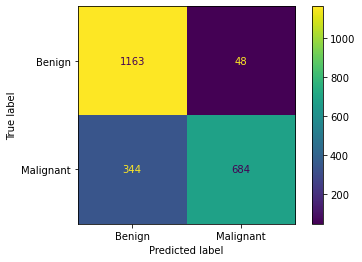

In [43]:
# Plot confusion matrix:
predictions = (model.predict(val_img) > 0.5).astype("int32")
cm = confusion_matrix(val_labels, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Benign', 'Malignant'])
disp.plot()
plt.show()

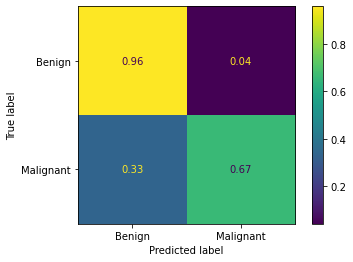

In [67]:
# Plot confusion matrix with percentages:
predictions = (model.predict(val_img) > 0.5).astype("int32")
cm = confusion_matrix(val_labels, predictions, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Benign', 'Malignant'])
disp.plot()
plt.show()

In [26]:
# Evaluate train and validation set:
results_train = model.evaluate(train_img, train_labels)
results_validation = model.evaluate(val_img, val_labels)


# Construct a new dataframe to save results:
baseline_results = pd.DataFrame(columns = ['Loss' , 'Accuracy', 'Recall', 'Precision', 'AUC'],
                      index = ['Train', 'Validation'])

for i in range(5):
    baseline_results[baseline_results.columns[i]]['Train'] = results_train[i]
    baseline_results[baseline_results.columns[i]]['Validation'] = results_validation[i]
    
baseline_results

70/70 [==============================] - 0s 2ms/step - loss: 0.3734 - accuracy: 0.8249 - recall: 0.6654 - precision: 0.9344 - auc: 0.9201


,Loss,Accuracy,Recall,Precision,AUC
Train,0.325581,0.842846,0.693281,0.950918,0.939903
Validation,0.373363,0.824922,0.66537,0.934426,0.920131


In [50]:
model.save("../Saved_Models/baseline_model.h5")
print("Saved model to disk")

Saved model to disk


In [68]:
# Save the baseline results
baseline_results.to_csv('../Saved_Models/baseline_results.csv', index=False)

**Analysis:** We got 84% accuracy for training and 82% accuracy for validation set for baseline model.

### 3.2. Convolutional Neural Network

In [28]:
# Create the architecture of the model
cnn_model = models.Sequential()

cnn_model.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=(64, 64, 3)))
cnn_model.add(layers.MaxPooling2D(2,2))

cnn_model.add(layers.Conv2D(64, (3,3), activation='relu'))
cnn_model.add(layers.MaxPooling2D(2,2))

cnn_model.add(layers.Flatten())
cnn_model.add(layers.Dense(128, activation='relu'))
cnn_model.add(layers.Dense(1, activation='sigmoid'))

In [54]:
cnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 29, 29, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 12544)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               1605760   
_________________________________________________________________
dense_5 (Dense)              (None, 1)                

In [30]:
# Compile and fit the model:
cnn_model.compile(optimizer='sgd',
              loss='binary_crossentropy',
             metrics=['accuracy', 'Recall', 'Precision', 'AUC'])

cnn_history = cnn_model.fit(train_images,
                    train_labels,
                    epochs=30,
                    batch_size=32,  # mini batches of 32 units!
                    validation_data=(val_images, val_labels))

Epoch 1/30
280/280 [==============================] - 40s 142ms/step - loss: 0.6181 - accuracy: 0.6457 - recall: 0.3549 - precision: 0.7364 - auc: 0.7319 - val_loss: 0.7542 - val_accuracy: 0.5962 - val_recall: 0.1235 - val_precision: 0.9769 - val_auc: 0.8506
Epoch 2/30
280/280 [==============================] - 40s 141ms/step - loss: 0.5036 - accuracy: 0.7558 - recall: 0.6409 - precision: 0.7874 - auc: 0.8319 - val_loss: 0.5201 - val_accuracy: 0.7695 - val_recall: 0.9018 - val_precision: 0.6908 - val_auc: 0.8823
Epoch 3/30
280/280 [==============================] - 37s 134ms/step - loss: 0.4395 - accuracy: 0.7926 - recall: 0.7327 - precision: 0.7986 - auc: 0.8767 - val_loss: 0.4298 - val_accuracy: 0.7928 - val_recall: 0.6955 - val_precision: 0.8256 - val_auc: 0.8916
Epoch 4/30
280/280 [==============================] - 38s 136ms/step - loss: 0.3956 - accuracy: 0.8202 - recall: 0.7875 - precision: 0.8145 - auc: 0.9022 - val_loss: 0.4006 - val_accuracy: 0.8178 - val_recall: 0.8706 - val_

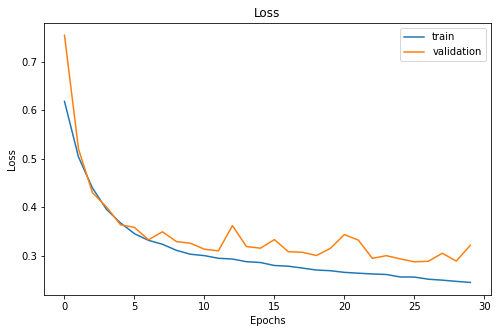

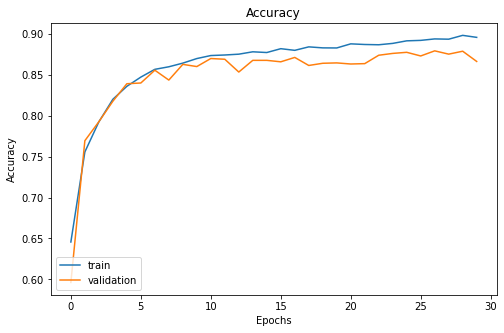

In [31]:
# Visualize the modeling results:
visualize_modeling_results(cnn_history)

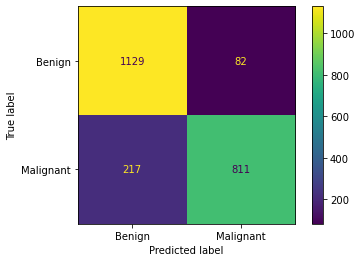

In [44]:
# Plot confusion matrix:
cnn_predictions = (cnn_model.predict(val_images) > 0.5).astype("int32")
cnn_cm = confusion_matrix(val_labels, cnn_predictions)
cnn_disp = ConfusionMatrixDisplay(confusion_matrix=cnn_cm, display_labels=['Benign', 'Malignant'])
cnn_disp.plot()
plt.show()

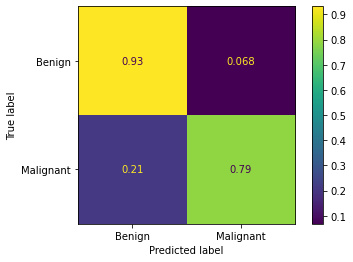

In [66]:
# Plot confusion matrix with percentages:
cnn_predictions = (cnn_model.predict(val_images) > 0.5).astype("int32")
cnn_cm = confusion_matrix(val_labels, cnn_predictions, normalize='true')
cnn_disp = ConfusionMatrixDisplay(confusion_matrix=cnn_cm, display_labels=['Benign', 'Malignant'])
cnn_disp.plot()
plt.show()

In [34]:
# Evaluate train and validation set:
cnn_results_train = cnn_model.evaluate(train_images, train_labels)
cnn_results_validation = cnn_model.evaluate(val_images, val_labels)


# Construct a new dataframe to save results:
cnn_results = pd.DataFrame(columns = ['Loss' , 'Accuracy', 'Recall', 'Precision', 'AUC'],
                      index = ['Train', 'Validation'])

for i in range(5):
    cnn_results[cnn_results.columns[i]]['Train'] = cnn_results_train[i]
    cnn_results[cnn_results.columns[i]]['Validation'] = cnn_results_validation[i]
    
cnn_results

70/70 [==============================] - 1s 17ms/step - loss: 0.3215 - accuracy: 0.8665 - recall: 0.7889 - precision: 0.9082 - auc: 0.9444


,Loss,Accuracy,Recall,Precision,AUC
Train,0.253835,0.891991,0.816943,0.939793,0.965246
Validation,0.321512,0.866458,0.788911,0.908175,0.944406


In [49]:
cnn_model.save("../Saved_Models/cnn_model.h5")
print("Saved model to disk")

Saved model to disk


In [69]:
# Save the model results
cnn_results.to_csv('../Saved_Models/cnn_results.csv', index=False)

**Analysis:** The First CNN model has improved accuracy results compared to the baseline model, multi-layer . We got 89% accuracy for training and 86% accuracy for validation set. We will comtinue iterating on CNN model to improve model accuracy.

### 3.3. Iterating on Convolutional Neural Networks

To improve the modeling results of baseline and first convolutional neural network model, I began iterating on convolutional neural networks. I will first add more convolutional and batch normalization layers to improve model performance:

#### First Iteration

In [57]:
# Create the architecture of the model
cnn2_model = models.Sequential()

cnn2_model.add(layers.Conv2D(256, (3,3), activation='relu', input_shape=(64, 64, 3)))
cnn2_model.add(layers.MaxPooling2D(2,2))

cnn2_model.add(layers.Conv2D(64, (3,3), activation='relu'))
cnn2_model.add(layers.MaxPooling2D(2,2))

cnn2_model.add(Conv2D(32, kernel_size=(3,3), activation='relu'))
cnn2_model.add(BatchNormalization())
cnn2_model.add(Activation('relu'))
cnn2_model.add(MaxPooling2D(2,2))

cnn2_model.add(layers.Flatten())
cnn2_model.add(layers.Dense(16, activation='relu'))
cnn2_model.add(layers.Dense(1, activation='sigmoid'))

In [58]:
cnn2_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 62, 62, 256)       7168      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 31, 31, 256)       0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 29, 29, 64)        147520    
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 12, 12, 32)        18464     
_________________________________________________________________
batch_normalization_2 (Batch (None, 12, 12, 32)        128       
_________________________________________________________________
activation_2 (Activation)    (None, 12, 12, 32)       

In [59]:
# Compile and fit the model:
cnn2_model.compile(optimizer='sgd',
              loss='binary_crossentropy',
             metrics=['accuracy', 'Recall', 'Precision', 'AUC'])

cnn2_history = cnn2_model.fit(train_images,
                    train_labels,
                    epochs=30,
                    batch_size=32,  # mini batches of 32 units!
                    validation_data=(val_images, val_labels))

Epoch 1/30
280/280 [==============================] - 122s 436ms/step - loss: 0.3783 - accuracy: 0.8355 - recall: 0.8089 - precision: 0.8285 - auc: 0.9134 - val_loss: 0.4627 - val_accuracy: 0.8455 - val_recall: 0.8512 - val_precision: 0.8193 - val_auc: 0.9171
Epoch 2/30
280/280 [==============================] - 196s 699ms/step - loss: 0.3270 - accuracy: 0.8598 - recall: 0.8367 - precision: 0.8548 - auc: 0.9332 - val_loss: 0.3606 - val_accuracy: 0.8414 - val_recall: 0.9027 - val_precision: 0.7844 - val_auc: 0.9313
Epoch 3/30
280/280 [==============================] - 195s 696ms/step - loss: 0.3120 - accuracy: 0.8679 - recall: 0.8471 - precision: 0.8625 - auc: 0.9389 - val_loss: 0.3374 - val_accuracy: 0.8450 - val_recall: 0.8901 - val_precision: 0.7963 - val_auc: 0.9334
Epoch 4/30
280/280 [==============================] - 189s 675ms/step - loss: 0.3078 - accuracy: 0.8673 - recall: 0.8432 - precision: 0.8643 - auc: 0.9406 - val_loss: 0.4365 - val_accuracy: 0.8129 - val_recall: 0.6352 - 

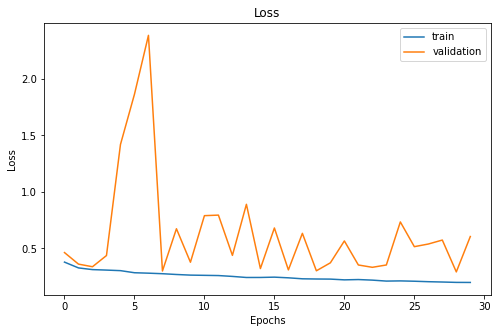

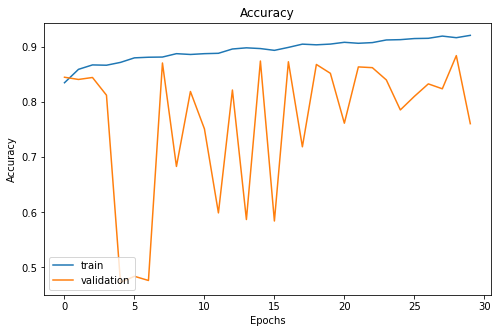

In [60]:
# Visualize the modeling results:
visualize_modeling_results(cnn2_history)

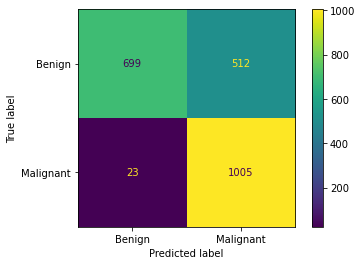

In [61]:
# Plot confusion matrix:
cnn2_predictions = (cnn2_model.predict(val_images) > 0.5).astype("int32")
cnn2_cm = confusion_matrix(val_labels, cnn2_predictions)
cnn2_disp = ConfusionMatrixDisplay(confusion_matrix=cnn2_cm, display_labels=['Benign', 'Malignant'])
cnn2_disp.plot()
plt.show()

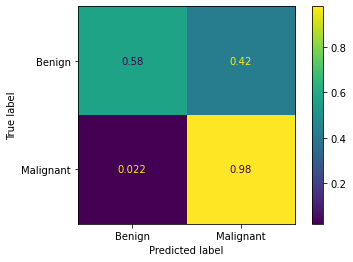

In [62]:
# Plot confusion matrix with percentages:
cnn2_predictions = (cnn2_model.predict(val_images) > 0.5).astype("int32")
cnn2_cm = confusion_matrix(val_labels, cnn2_predictions, normalize='true')
cnn2_disp = ConfusionMatrixDisplay(confusion_matrix=cnn2_cm, display_labels=['Benign', 'Malignant'])
cnn2_disp.plot()
plt.show()

In [64]:
# Evaluate train and validation set:
cnn2_results_train = cnn2_model.evaluate(train_images, train_labels)
cnn2_results_validation = cnn2_model.evaluate(val_images, val_labels)


# Construct a new dataframe to save results:
cnn2_results = pd.DataFrame(columns = ['Loss' , 'Accuracy', 'Recall', 'Precision', 'AUC'],
                      index = ['Train', 'Validation'])

for i in range(5):
    cnn2_results[cnn2_results.columns[i]]['Train'] = cnn2_results_train[i]
    cnn2_results[cnn2_results.columns[i]]['Validation'] = cnn2_results_validation[i]
    
cnn2_results

70/70 [==============================] - 7s 96ms/step - loss: 0.6047 - accuracy: 0.7611 - recall: 0.9776 - precision: 0.6625 - auc: 0.9443


,Loss,Accuracy,Recall,Precision,AUC
Train,0.527665,0.768346,0.991723,0.66634,0.968038
Validation,0.604719,0.761054,0.977626,0.662492,0.944324


In [65]:
cnn2_model.save("../Saved_Models/cnn2_model.h5")
print("Saved model to disk")

Saved model to disk


In [70]:
# Save the model results
cnn2_results.to_csv('../Saved_Models/cnn2_results.csv', index=False)

**Analysis:** Adding one convolutional and batch normalizationa layers result in decrease in accuracy. But, we got great recall score. We need to train more complex model, so we will add more pooling and convolution layers!

#### Second Iteration 

In [71]:
# Create the architecture of the model
cnn3_model = models.Sequential()

cnn3_model.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=(64,64,3)))
cnn3_model.add(layers.BatchNormalization())
cnn3_model.add(layers.MaxPooling2D(2,2))

cnn3_model.add(layers.Conv2D(64, (3,3), activation='relu'))
cnn3_model.add(layers.BatchNormalization())
cnn3_model.add(layers.MaxPooling2D(2,2))

cnn3_model.add(layers.Conv2D(128, (3,3), activation='relu'))
cnn3_model.add(layers.BatchNormalization())
cnn3_model.add(layers.MaxPooling2D(2,2))

cnn3_model.add(layers.Flatten())
cnn3_model.add(layers.Dense(128, activation='relu'))
cnn3_model.add(layers.Dense(1, activation='sigmoid'))

In [72]:
cnn3_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 62, 62, 32)        896       
_________________________________________________________________
batch_normalization_3 (Batch (None, 62, 62, 32)        128       
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 29, 29, 64)        18496     
_________________________________________________________________
batch_normalization_4 (Batch (None, 29, 29, 64)        256       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 12, 12, 128)      

In [73]:
# Compile and fit the model:
cnn3_model.compile(optimizer='sgd',
              loss='binary_crossentropy',
             metrics=['accuracy', 'Recall', 'Precision', 'AUC'])

cnn3_history = cnn3_model.fit(train_images,
                    train_labels,
                    epochs=30,
                    batch_size=32,  # mini batches of 32 units!
                    validation_data=(val_images, val_labels))

Epoch 1/30
280/280 [==============================] - 50s 179ms/step - loss: 0.3320 - accuracy: 0.8576 - recall: 0.8340 - precision: 0.8525 - auc: 0.9327 - val_loss: 0.5148 - val_accuracy: 0.7195 - val_recall: 0.4008 - val_precision: 0.9717 - val_auc: 0.9068
Epoch 2/30
280/280 [==============================] - 61s 220ms/step - loss: 0.2590 - accuracy: 0.8933 - recall: 0.8756 - precision: 0.8901 - auc: 0.9581 - val_loss: 0.3328 - val_accuracy: 0.8473 - val_recall: 0.7432 - val_precision: 0.9074 - val_auc: 0.9404
Epoch 3/30
280/280 [==============================] - 86s 309ms/step - loss: 0.2324 - accuracy: 0.9005 - recall: 0.8839 - precision: 0.8977 - auc: 0.9663 - val_loss: 0.3056 - val_accuracy: 0.8642 - val_recall: 0.8687 - val_precision: 0.8409 - val_auc: 0.9426
Epoch 4/30
280/280 [==============================] - 88s 315ms/step - loss: 0.2162 - accuracy: 0.9096 - recall: 0.8941 - precision: 0.9076 - auc: 0.9707 - val_loss: 0.4734 - val_accuracy: 0.7812 - val_recall: 0.9582 - val_

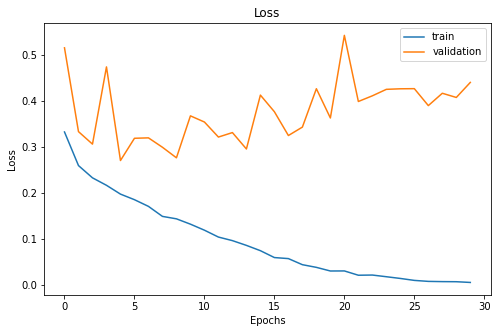

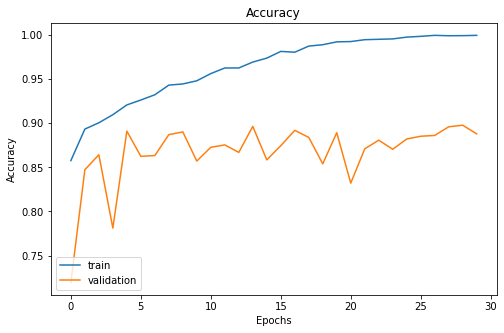

In [74]:
# Visualize the modeling results:
visualize_modeling_results(cnn3_history)

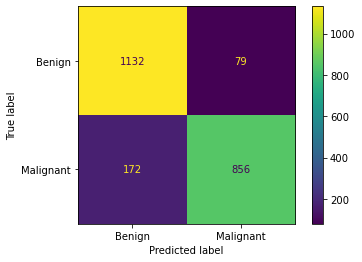

In [75]:
# Plot confusion matrix:
cnn3_predictions = (cnn3_model.predict(val_images) > 0.5).astype("int32")
cnn3_cm = confusion_matrix(val_labels, cnn3_predictions)
cnn3_disp = ConfusionMatrixDisplay(confusion_matrix=cnn3_cm, display_labels=['Benign', 'Malignant'])
cnn3_disp.plot()
plt.show()

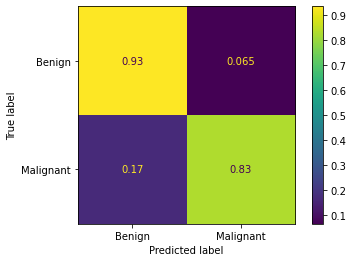

In [76]:
# Plot confusion matrix with percentages:
cnn3_predictions = (cnn3_model.predict(val_images) > 0.5).astype("int32")
cnn3_cm = confusion_matrix(val_labels, cnn3_predictions, normalize='true')
cnn3_disp = ConfusionMatrixDisplay(confusion_matrix=cnn3_cm, display_labels=['Benign', 'Malignant'])
cnn3_disp.plot()
plt.show()

In [77]:
# Evaluate train and validation set:
cnn3_results_train = cnn3_model.evaluate(train_images, train_labels)
cnn3_results_validation = cnn3_model.evaluate(val_images, val_labels)


# Construct a new dataframe to save results:
cnn3_results = pd.DataFrame(columns = ['Loss' , 'Accuracy', 'Recall', 'Precision', 'AUC'],
                      index = ['Train', 'Validation'])

for i in range(5):
    cnn3_results[cnn3_results.columns[i]]['Train'] = cnn3_results_train[i]
    cnn3_results[cnn3_results.columns[i]]['Validation'] = cnn3_results_validation[i]
    
cnn3_results

70/70 [==============================] - 2s 23ms/step - loss: 0.4397 - accuracy: 0.8879 - recall: 0.8327 - precision: 0.9155 - auc: 0.9425


,Loss,Accuracy,Recall,Precision,AUC
Train,0.0271566,0.990506,0.982473,0.996789,0.999655
Validation,0.439668,0.887896,0.832685,0.915508,0.942524


In [78]:
cnn3_model.save("../Saved_Models/cnn3_model.h5")
print("Saved model to disk")

Saved model to disk


In [79]:
# Save the model results
cnn3_results.to_csv('../Saved_Models/cnn3_results.csv', index=False)

**Analysis:** This CNN model is overfitting. We have 99% accuracy score for training set, but 88% accuracy score for validation set. We will add Dropout layers and introduce L2 regularization parameter into the layers of the next model.

#### Third Iteration 